# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Navigate to the repo

In [2]:
%cd /content/drive/MyDrive/adf_debug/AGFVisualization/
!ls

/content/drive/MyDrive/adf_debug/AGFVisualization
baselines		    pertubation_eval_from_hdf5.py
data			    README.md
generate_segmentation.py    requirements.txt
generate_visualizations.py  samples
imagenet_seg_eval.py	    segmentation_eval_from_hdf5.py
LICENSE			    train_multiclass.py
main.py			    tutorial.ipynb
modules			    utils


In [6]:
!pip install timm
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.3 MB/s 
     |████████████████████████████████| 596 kB 47.3 MB/s 
     |████████████████████████████████| 895 kB 40.4 MB/s 
     |████████████████████████████████| 3.3 MB 35.5 MB/s 
     |████████████████████████████████| 59 kB 6.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [7]:
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from utils import render
import imageio
import cv2
import os

from modules.vgg import vgg19
from data.imagenet_utils import CLS2IDX

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(torch.cuda.memory_summary(device=None, abbreviated=False))


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

# Examples

In [8]:
def normalize(tensor,
              mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225]):
    dtype = tensor.dtype
    mean = torch.as_tensor(mean, dtype=dtype, device=tensor.device)
    std = torch.as_tensor(std, dtype=dtype, device=tensor.device)
    tensor.sub_(mean[None, :, None, None]).div_(std[None, :, None, None])
    return tensor


# PATH variables
PATH = os.getcwd() + '/'
dataset = PATH + 'samples/'
save_path = PATH + 'results/'

# Dataset loader for sample images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
sample_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(dataset, transform=transform),
    batch_size=1,
    shuffle=False)

# Check CUDA
cuda = torch.cuda.is_available()
print(cuda)
device = torch.device("cuda" if cuda else "cpu")

def get_visualization(predictions, **kwargs):    
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])
    
    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(out[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)
    
    return model.AGF(**kwargs)


True


In [9]:
# Load model
model = vgg19(pretrained=True).to(device)
model = model.cuda()
model.eval();

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

## Dog-Cat

Top 5 classes:
	243 : bull mastiff    		value = 11.861	 prob = 46.1%
	245 : French bulldog  		value = 10.980	 prob = 19.1%
	254 : pug, pug-dog    		value = 10.928	 prob = 18.1%
	242 : boxer           		value = 9.964	 prob = 6.9%
	281 : tabby, tabby cat		value = 8.008	 prob = 1.0%
Top 5 classes:
	243 : bull mastiff    		value = 11.861	 prob = 46.1%
	245 : French bulldog  		value = 10.980	 prob = 19.1%
	254 : pug, pug-dog    		value = 10.928	 prob = 18.1%
	242 : boxer           		value = 9.964	 prob = 6.9%
	281 : tabby, tabby cat		value = 8.008	 prob = 1.0%


(-0.5, 671.5, 671.5, -0.5)

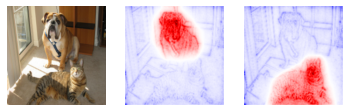

In [10]:
dog_cat_image = imageio.imread('samples/dog-cat.JPEG')
dog_cat_tensor = torch.tensor(dog_cat_image).permute(
    0, 1, 2).unsqueeze(0).to(device).float() / 255
# dog_cat_tensor = torch.tensor(dog_cat_image).unsqueeze(0).to(device).float() / 255
norm_data = normalize(dog_cat_tensor.clone())
out = model(norm_data)

# Compute Dog (top) Class Attribution Map
dog = get_visualization(out)
cat = get_visualization(out, class_id=[282])

dog = (render.hm_to_rgb(dog[0, 0].data.cpu().numpy(
), scaling=3, sigma=1, cmap='seismic') * 255).astype(np.uint8)
cat = (render.hm_to_rgb(cat[0, 0].data.cpu().numpy(
), scaling=3, sigma=1, cmap='seismic') * 255).astype(np.uint8)

fig, axs = plt.subplots(1, 3)

axs[0].imshow(
    (cv2.resize(np.transpose(dog_cat_image.T, axes=(1, 0, 2)), (672, 672))))
axs[0].axis('off')
axs[1].imshow(dog)
axs[1].axis('off')
axs[2].imshow(cat)
axs[2].axis('off')

## Visualize Folder

Top 5 classes:
	266 : miniature poodle                              		value = 13.294	 prob = 42.7%
	265 : toy poodle                                    		value = 13.094	 prob = 35.0%
	194 : Dandie Dinmont, Dandie Dinmont terrier        		value = 12.266	 prob = 15.3%
	267 : standard poodle                               		value = 10.614	 prob = 2.9%
	219 : cocker spaniel, English cocker spaniel, cocker		value = 9.832	 prob = 1.3%
Top 5 classes:
	237 : miniature pinscher         		value = 15.276	 prob = 63.7%
	165 : black-and-tan coonhound    		value = 13.767	 prob = 14.1%
	234 : Rottweiler                 		value = 13.466	 prob = 10.4%
	236 : Doberman, Doberman pinscher		value = 12.648	 prob = 4.6%
	434 : bath towel                 		value = 12.396	 prob = 3.6%
Top 5 classes:
	185 : Norfolk terrier                       		value = 18.597	 prob = 81.4%
	186 : Norwich terrier                       		value = 16.289	 prob = 8.1%
	192 : cairn, cairn terrier                  		value = 16.120	 p

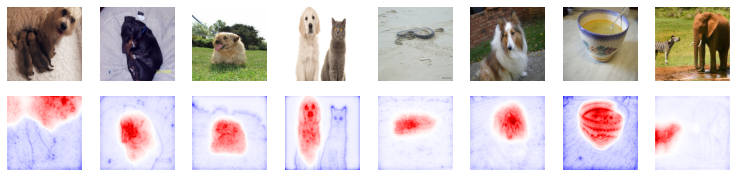

In [11]:
number_of_samples = len(sample_loader)

fig, axs = plt.subplots(2, number_of_samples, figsize=(13,3))

for batch_idx, (data, target) in enumerate(sample_loader):
    data, target = data.to(device).requires_grad_(), target.to(device)
    
    # Input image
    image = data[0, :, :, :].cpu()
    _img = np.uint8(image.data.cpu().numpy() * 255).transpose(1, 2, 0)
    axs[0, batch_idx].imshow(_img)
    axs[0, batch_idx].axis('off')
    
    # Input data
    norm_data = normalize(data.clone())
    out = model(norm_data)
    
    # Compute Class Attribution Map
    cam = get_visualization(out,
                            lmd=10,
                            no_fx=False,
                            no_m=False,
                            gradcam=False,
                            no_reg=False,
                            no_fgx=False,
                            no_a=False)    

    # Render CAM
    filename = save_path + str(batch_idx + 1)
    filename_new = filename
    maps = (render.hm_to_rgb(cam[0, 0].data.cpu().numpy(), scaling=3, sigma=1, cmap='seismic') * 255).astype(np.uint8)
    maps = cv2.resize(maps, (224, 224))

    # Visualization
    axs[1, batch_idx].imshow(maps)
    axs[1, batch_idx].axis('off')

In [12]:
# bing